#🌍 Análise Geoespacial: Cobertura de Saúde Pública vs. Censo 2022
##Engenharia de Dados e Inteligência em Saúde

Este projeto investiga a eficácia da Atenção Primária à Saúde no Brasil, cruzando dados oficiais do DATASUS com a população real reportada pelo IBGE (Censo 2022).


Desafio Técnico: Normalização de identificadores municipais divergentes entre bases federais e tratamento de escalas populacionais logarítmicas.

In [1]:
!pip install geopandas
!pip install geobr
!pip install plotly


In [3]:
import pandas as pd
import numpy as np
from google.colab import files # eu usei o google colab esta biblioteca permite que você selecione um arquivo do seu computador
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

uploaded = files.upload()
nome_do_arquivo = list(uploaded.keys())[0]


df = pd.read_csv(nome_do_arquivo, skiprows=2, header=0, sep=',')

print("Arquivo CSV carregado com sucesso, pulando a primeira linha!")
print(df.head())

Saving popIBGEdadosDATASUS.csv to popIBGEdadosDATASUS.csv
Arquivo CSV carregado com sucesso, pulando a primeira linha!
          chave_sus_ibge  UF  COD. MUNIC      NOME DO MUNICÍPIO  \
0  ROALTAFLORESTAD'OESTE  RO        15.0  Alta Floresta D'Oeste   
1            ROARIQUEMES  RO        23.0              Ariquemes   
2               ROCABIXI  RO        31.0                 Cabixi   
3               ROCACOAL  RO        49.0                 Cacoal   
4           ROCEREJEIRAS  RO        56.0             Cerejeiras   

  População Censo 2022 POP_COBERTA_SUS pop_coberta_DATASUS  taxa de cobertura  
0               21 494           22516            22516,00                  1  
1               96 833          68,425            68425,00  0,706628938481716  
2                5 351           5,067             5067,00  0,946925808260138  
3               86 887          52,325            52325,00  0,602218974069769  
4               15 890          16,088            16088,00                  1 

In [35]:
import pandas as pd
import numpy as np
import plotly.express as px

# --- 1. Carregamento Seguro do Arquivo ---
# Tentamos os nomes mais comuns para evitar o erro "FileNotFound"
lista_arquivos = [
    'popIBGEdados DATASUS.csv',       # Nome original com espaço
    'popIBGEdadosDATASUS.csv',        # Nome sem espaço
    'popIBGEdados DATASUS (1).csv'    # Nome com cópia
]

df_dados = None
for arquivo in lista_arquivos:
    try:
        df_dados = pd.read_csv(arquivo, skiprows=2, header=0, sep=',', encoding='utf-8')
        print(f"✅ Arquivo carregado: {arquivo}")
        break
    except FileNotFoundError:
        continue

if df_dados is None:
    print("❌ ERRO: Nenhum arquivo encontrado. Faça o upload do CSV novamente.")
else:
    # --- 2. Renomeação Inteligente (Com e Sem Acento) ---
    # Cria um mapa de renomeação que funciona para ambos os casos
    mapa_colunas = {
        'COD. MUNIC': 'CD_IBGE',
        'NOME DO MUNICÍPIO': 'NM_MUNICIPIO',  # Com acento
        'NOME DO MUNICIPIO': 'NM_MUNICIPIO',  # Sem acento
        'População Censo 2022': 'POP_CENSO_2022',
        'taxa de cobertura': 'TAXA_COBERTURA_FINAL'
    }
    df_dados.rename(columns=mapa_colunas, inplace=True)

    # --- 3. Seleção e Cópia ---
    colunas_necessarias = ['CD_IBGE', 'NM_MUNICIPIO', 'UF', 'POP_CENSO_2022', 'TAXA_COBERTURA_FINAL']
    # Garante que só selecionamos as colunas que realmente existem no arquivo
    colunas_existentes = [c for c in colunas_necessarias if c in df_dados.columns]
    df_analise = df_dados[colunas_existentes].copy()

    # --- 4. Limpeza da População ---
    if 'POP_CENSO_2022' in df_analise.columns:
        df_analise['POP_CENSO_2022'] = (
            df_analise['POP_CENSO_2022'].astype(str)
            .str.replace(' ', '', regex=False)
            .str.replace('.', '', regex=False)  # Remove ponto de milhar
            .str.replace(',', '.', regex=False) # Troca vírgula decimal
        )
        df_analise['POP_CENSO_2022'] = pd.to_numeric(df_analise['POP_CENSO_2022'], errors='coerce').fillna(1)

    # --- 5. Limpeza da Taxa de Cobertura ---
    if 'TAXA_COBERTURA_FINAL' in df_analise.columns:
        df_analise['TAXA_COBERTURA_FINAL'] = (
            df_analise['TAXA_COBERTURA_FINAL'].astype(str)
            .str.replace(',', '.', regex=False)
        )
        df_analise['TAXA_COBERTURA_FINAL'] = pd.to_numeric(df_analise['TAXA_COBERTURA_FINAL'], errors='coerce')

        # Correção da escala (se estiver 0.95 vira 95.0)
        if df_analise['TAXA_COBERTURA_FINAL'].max() <= 1.5:
            df_analise['TAXA_COBERTURA_FINAL'] = df_analise['TAXA_COBERTURA_FINAL'] * 100

        df_analise['TAXA_COBERTURA_FINAL'] = df_analise['TAXA_COBERTURA_FINAL'].clip(upper=100)

    # --- 6. Geração do Gráfico Interativo ---
    print("📊 Gerando gráfico...")

    # Remove linhas vazias para não quebrar o gráfico
    df_plotagem = df_analise.dropna(subset=['POP_CENSO_2022', 'TAXA_COBERTURA_FINAL']).copy()

    # Evita erro de log(0) substituindo 0 por 1
    df_plotagem['POP_CENSO_2022'] = df_plotagem['POP_CENSO_2022'].replace(0, 1)

    fig = px.scatter(
        df_plotagem,
        x=np.log10(df_plotagem['POP_CENSO_2022']),
        y='TAXA_COBERTURA_FINAL',
        hover_name='NM_MUNICIPIO',
        color='UF',
        title='Taxa de Cobertura vs. População Municipal (Escala Logarítmica)',
        labels={'x': 'População (Log10)', 'TAXA_COBERTURA_FINAL': 'Cobertura (%)'},
        template='plotly_dark'
    )

    fig.show()

✅ Arquivo carregado: popIBGEdadosDATASUS.csv
📊 Gerando gráfico...


Baixando malha do IBGE...
Municípios coloridos: 5545


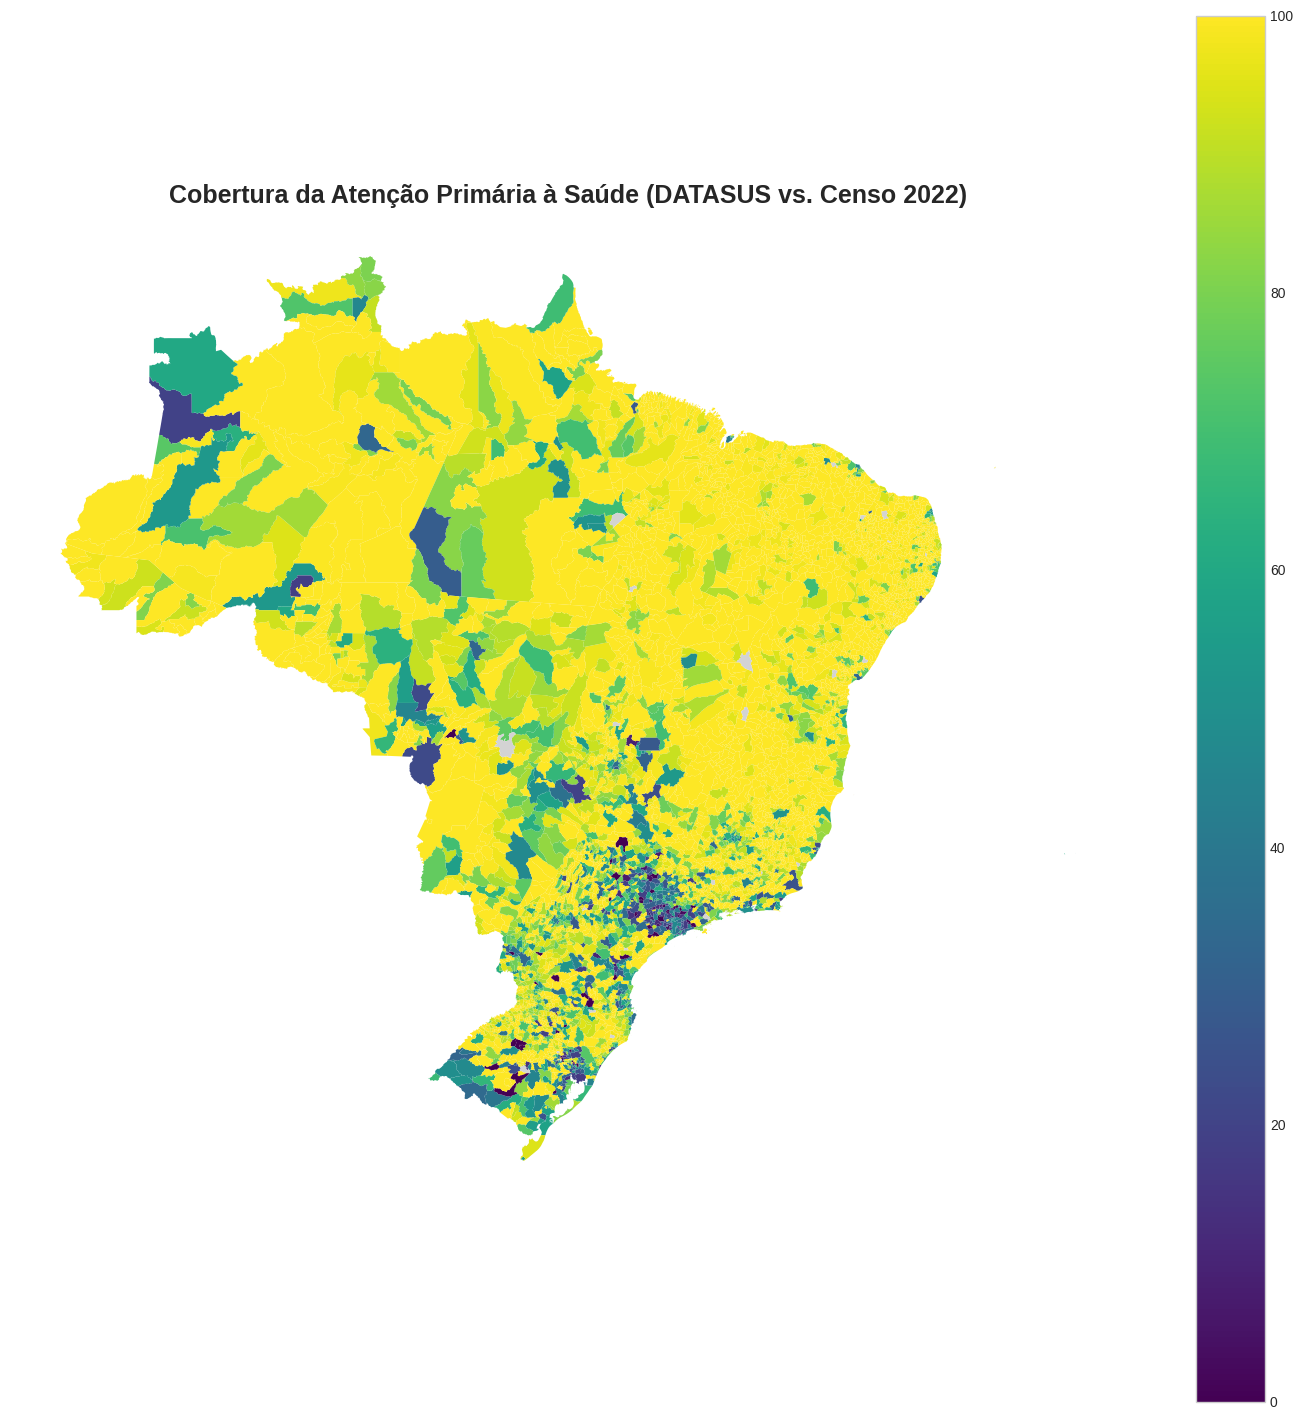

In [38]:
import geobr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar Malha do IBGE e Limpar Código
print("Baixando malha do IBGE...")
gdf_municipios = geobr.read_municipality(year=2020)
# Garante 7 dígitos limpos no mapa
gdf_municipios['CD_IBGE_FINAL'] = gdf_municipios['code_muni'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(7)

# 2. Reconstruir a chave nos seus DADOS (A CORREÇÃO ESTÁ AQUI)
codigos_uf = {
    'RO': '11', 'AC': '12', 'AM': '13', 'RR': '14', 'PA': '15', 'AP': '16', 'TO': '17',
    'MA': '21', 'PI': '22', 'CE': '23', 'RN': '24', 'PB': '25', 'PE': '26', 'AL': '27',
    'SE': '28', 'BA': '29', 'MG': '31', 'ES': '32', 'RJ': '33', 'SP': '35', 'PR': '41',
    'SC': '42', 'RS': '43', 'MS': '50', 'MT': '51', 'GO': '52', 'DF': '53'
}

# Mapeia o Estado
df_analise['COD_ESTADO'] = df_analise['UF'].map(codigos_uf)

# Remove o ponto decimal (.0) ANTES de preencher com zeros
df_analise['CD_MUNICIPIO_5D'] = (
    df_analise['CD_IBGE'].astype(str)
    .str.replace(r'\.0$', '', regex=True) # Remove .0 se existir
    .str.zfill(5) # Garante 5 dígitos (ex: 15 vira 00015)
)

# Cria a chave final (Ex: 11 + 00015 = 1100015)
df_analise['CD_IBGE_FINAL'] = df_analise['COD_ESTADO'].astype(str) + df_analise['CD_MUNICIPIO_5D']

# 3. Cruzamento (Merge)
gdf_final = gdf_municipios.merge(df_analise, on='CD_IBGE_FINAL', how='left')

# Verificação visual para você saber se deu certo
print(f"Municípios coloridos: {gdf_final['TAXA_COBERTURA_FINAL'].notna().sum()}")

# 4. Gerar e Salvar o Mapa
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
gdf_final.plot(
    column='TAXA_COBERTURA_FINAL',
    ax=ax,
    legend=True,
    cmap='viridis',
    missing_kwds={"color": "lightgrey", "label": "Dados Ausentes"},
    vmax=100, vmin=0
)

ax.set_title('Cobertura da Atenção Primária à Saúde (DATASUS vs. Censo 2022)', fontsize=18, fontweight='bold')
ax.set_axis_off()

import os

# Cria a pasta 'visualizations' se ela não existir
os.makedirs('visualizations', exist_ok=True)

# Agora o salvamento vai funcionar
plt.savefig("visualizations/mapa_cobertura_saude.png", dpi=300, bbox_inches='tight')
plt.show()
